<center>

# E-Commerce Business-Oriented Exploratory Data Analysis

This notebook focuses on business-driven analysis of an e-commerce dataset.
The goal is to extract actionable insights related to revenue, customer behavior,
product performance, and growth trends.

</center>

## Business Scope

This analysis focuses on evaluating overall business performance of the e-commerce platform.

### Core Business Questions

1. What is the total revenue generated?
2. How many orders were successfully delivered?
3. What is the average order value?
4. How does revenue evolve over time?
5. Which product categories drive the most revenue?

### Analysis Perspective

This notebook will focus only on **delivered orders**, since cancelled or unavailable orders do not represent realized revenue.

## 0. Key Performance Indicators (KPI Summary)

**This section displays the main business metrics after data processing:**

In [1]:
"""Display KPI Summary Dashboard"""
print("\n" + "="*70)
print("KEY PERFORMANCE INDICATORS (KPI) SUMMARY".center(70))
print("="*70 + "\n")
print("Key metrics to be calculated and displayed:")
print("   • Total Revenue Generated")
print("   • Total Delivered Orders")
print("   • Average Order Value (AOV)")
print("   • Month-over-Month Revenue Growth")
print("   • Top Revenue-Generating Categories\n")
print("="*70 + "\n")


               KEY PERFORMANCE INDICATORS (KPI) SUMMARY               

Key metrics to be calculated and displayed:
   • Total Revenue Generated
   • Total Delivered Orders
   • Average Order Value (AOV)
   • Month-over-Month Revenue Growth
   • Top Revenue-Generating Categories




## 1. Environment Setup

In [2]:
"""Initialize libraries and global chart configuration for consistent visualization"""
# Core Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

# Global Chart Configuration - Ensures visual consistency across all plots
FIG_WIDTH, FIG_HEIGHT = 12, 6
COLOR_PRIMARY = "#2E86AB"          # Primary blue for main visualizations
COLOR_ACCENT = "#A23B72"            # Magenta accent for highlights
COLOR_PALETTE = sns.color_palette("Set2", 10)  # 10-color palette for categories

## 2. Data Loading

In [3]:
"""Load all required datasets with error handling"""
try:
    orders = pd.read_csv("../data/raw/olist_orders_dataset.csv")
    order_items = pd.read_csv("../data/raw/olist_order_items_dataset.csv")
    products = pd.read_csv("../data/raw/olist_products_dataset.csv")
    customers = pd.read_csv("../data/raw/olist_customers_dataset.csv")
    category_translation = pd.read_csv("../data/raw/product_category_name_translation.csv")
    print("✓ All datasets loaded successfully")
except FileNotFoundError as e:
    print(f"✗ Error loading data: {e}")
    print("Please ensure all CSV files are in ../data/raw/ directory")

✓ All datasets loaded successfully


## 3. Data Validation & Cleaning

#### 3.1 Dataset Shape Check

This section validates dataset structure and basic structural consistency before analysis.

In [4]:
print("===== DATASET SHAPE CHECK =====\n")

datasets = {
    "Orders": orders,
    "Order Items": order_items,
    "Products": products,
    "Customers": customers,
    "Category Translation": category_translation
}

for name, df in datasets.items():
    print(f"{name}: {df.shape}")

===== DATASET SHAPE CHECK =====

Orders: (99441, 8)
Order Items: (112650, 7)
Products: (32951, 9)
Customers: (99441, 5)
Category Translation: (71, 2)


#### 3.2 Orders Structure Analysis

Inspecting column types, null values and key identifiers.

In [5]:
orders.head()
orders.info()
orders["order_status"].value_counts()

<class 'pandas.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   order_id                       99441 non-null  str  
 1   customer_id                    99441 non-null  str  
 2   order_status                   99441 non-null  str  
 3   order_purchase_timestamp       99441 non-null  str  
 4   order_approved_at              99281 non-null  str  
 5   order_delivered_carrier_date   97658 non-null  str  
 6   order_delivered_customer_date  96476 non-null  str  
 7   order_estimated_delivery_date  99441 non-null  str  
dtypes: str(8)
memory usage: 21.9 MB


order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

#### 3.3 Convert Date Columns

In [6]:
date_columns = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col])

#### 3.4 Filter Delivered Orders

In [7]:
orders = orders[orders["order_status"] == "delivered"]

#### 3.5 Merge Orders with Order Items

In [8]:
df = orders.merge(order_items, on="order_id", how="inner")

df = df.merge(customers[["customer_id", "customer_unique_id"]], on="customer_id", how="left")

## 4. Feature Engineering

#### 4.1 Revenue Column

In [9]:
df["revenue"] = df["price"] + df["freight_value"]
df[["price", "freight_value", "revenue"]].head()

,price,freight_value,revenue
0,29.99,8.72,38.71
1,118.70,22.76,141.46
2,159.90,19.22,179.12
3,45.00,27.20,72.20
4,19.90,8.72,28.62


## 5. Key Business Metrics (KPI Section)

#### 5.1 Total Revenue

In [10]:
total_revenue = df["revenue"].sum()
print(f"Total Revenue: ${total_revenue:,.2f}")

Total Revenue: $15,419,773.75


#### 5.2 Total Delivered Orders

In [11]:
total_orders = df["order_id"].nunique()
print(f"Total Delivered Orders: {total_orders:,}")

Total Delivered Orders: 96,478


#### 5.3 Average Order Value

In [12]:
order_revenue = df.groupby("order_id")["revenue"].sum()
aov = order_revenue.mean()
print(f"Average Order Value: ${aov:,.2f}")


Average Order Value: $159.83


## 6. Revenue Trend Over Time

Revenue shows strong upward momentum in late 2017, followed by stabilization in 2018. Growth appears acquisition-driven rather than retention-driven.

#### 6.1 Create Year-Month Column

In [13]:
df["Year/Month"] = df["order_purchase_timestamp"].dt.to_period("M")

#### 6.2 Calculate Monthly Revenue

In [14]:
monthly_revenue = df.groupby("Year/Month")["revenue"].sum().reset_index()
monthly_revenue.head()

,Year/Month,revenue
0,2016-09,143.46
1,2016-10,46490.66
2,2016-12,19.62
3,2017-01,127482.37
4,2017-02,271239.32


#### 6.3 Datetime For Chart

In [15]:
monthly_revenue["Year/Month"] = monthly_revenue["Year/Month"].astype(str)
monthly_revenue["Year/Month"] = pd.to_datetime(monthly_revenue["Year/Month"])

#### 6.4 Trend Chart

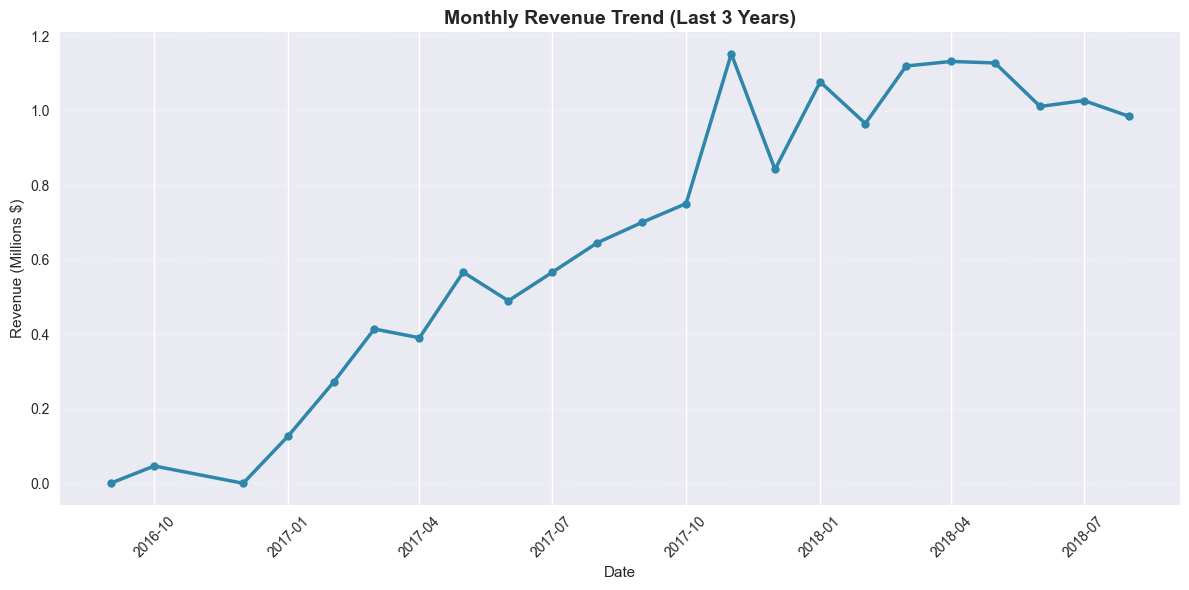

In [16]:
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

plt.plot(monthly_revenue["Year/Month"], 
         monthly_revenue["revenue"] / 1000000,
         marker="o",
         linewidth=2.5,
         color=COLOR_PRIMARY,
         markersize=6)

plt.title("Monthly Revenue Trend (Last 3 Years)", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=11)
plt.ylabel("Revenue (Millions $)", fontsize=11)
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

## 7. Category Revenue Analysis

#### 7.1 Merge with products to get category

In [17]:
"""Enrich order data with product category information"""
df = df.merge(products[["product_id", "product_category_name"]], on="product_id", how="left")

#### 7.2 Merge with translation to get English names

In [18]:
"""Merge English category names for better readability and analysis"""
df = df.merge(category_translation, on="product_category_name", how="left")

#### 7.3 Replace null categories

In [19]:
df["product_category_name_english"] = df["product_category_name_english"].fillna("Unknown")

#### 7.4 Calculate revenue by category

In [ ]:
category_revenue = df.groupby("product_category_name_english")["revenue"].sum().sort_values(ascending=False).reset_index()

category_revenue.head(10)

,product_category_name_english,revenue
0,health_beauty,1412089.53
1,watches_gifts,1264333.12
2,bed_bath_table,1225209.26
3,sports_leisure,1118256.91
4,computers_accessories,1032723.77
5,furniture_decor,880329.92
6,housewares,758392.25
7,cool_stuff,691680.89
8,auto,669454.75
9,garden_tools,567145.68


#### 7.5 Contribution Percentage

In [21]:
category_revenue["Contribution %"] = (category_revenue["revenue"] / category_revenue["revenue"].sum()) * 100
category_revenue.head(10)

,product_category_name_english,revenue,Contribution %
0,health_beauty,1412089.53,9.157654
1,watches_gifts,1264333.12,8.199427
2,bed_bath_table,1225209.26,7.945702
3,sports_leisure,1118256.91,7.252097
4,computers_accessories,1032723.77,6.697399
5,furniture_decor,880329.92,5.709098
6,housewares,758392.25,4.918310
7,cool_stuff,691680.89,4.485675
8,auto,669454.75,4.341534
9,garden_tools,567145.68,3.678042


#### 7.6 Top 10 Visualization

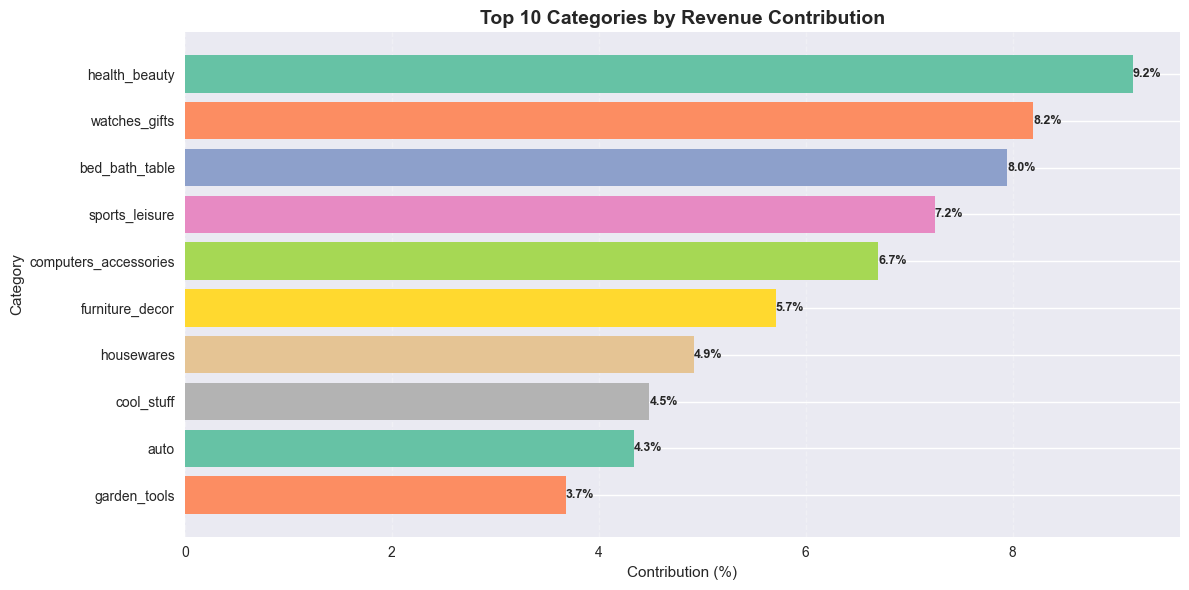

In [22]:
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

top10 = category_revenue.head(10)
top10["Contribution %"] = top10["Contribution %"].round(2)

# Create bar chart with color palette
bars = plt.barh(
    top10["product_category_name_english"],
    top10["Contribution %"],
    color=COLOR_PALETTE
)

plt.gca().invert_yaxis()

# Enhanced styling
plt.title("Top 10 Categories by Revenue Contribution", fontsize=14, fontweight="bold")
plt.xlabel("Contribution (%)", fontsize=11)
plt.ylabel("Category", fontsize=11)
plt.grid(axis="x", alpha=0.3, linestyle="--")

# Add value labels on bars for clarity
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.1f}%',
             ha='left', va='center', fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()

#### 7.7 Cumulative Contribution Calculation

In [23]:
"""Calculate Pareto distribution for identifying revenue concentration (80/20 rule)"""
# Ensure categories are sorted by revenue (descending)
category_revenue = (
    category_revenue
        .sort_values("revenue", ascending=False)
        .reset_index(drop=True)
)

# Calculate cumulative contribution percentage
category_revenue["Cumulative %"] = (
    category_revenue["Contribution %"]
        .cumsum()
)

category_revenue.head(10)

,product_category_name_english,revenue,Contribution %,Cumulative %
0,health_beauty,1412089.53,9.157654,9.157654
1,watches_gifts,1264333.12,8.199427,17.357081
2,bed_bath_table,1225209.26,7.945702,25.302783
3,sports_leisure,1118256.91,7.252097,32.554880
4,computers_accessories,1032723.77,6.697399,39.252279
5,furniture_decor,880329.92,5.709098,44.961376
6,housewares,758392.25,4.918310,49.879686
7,cool_stuff,691680.89,4.485675,54.365361
8,auto,669454.75,4.341534,58.706895
9,garden_tools,567145.68,3.678042,62.384937


#### 7.8 Identify 80% Revenue Threshold

In [24]:
"""Identify categories that contribute to 80% of total revenue"""
pareto_80 = category_revenue[category_revenue["Cumulative %"] <= 80]
num_categories_80 = pareto_80.shape[0]
print(f"\n📌 Pareto Insight (80/20 Rule):")
print(f"   Number of categories covering 80% of revenue: {num_categories_80}")
print(f"   Percentage of total categories: {(num_categories_80 / len(category_revenue) * 100):.1f}%")


📌 Pareto Insight (80/20 Rule):
   Number of categories covering 80% of revenue: 17
   Percentage of total categories: 23.6%


#### 7.9 Pareto Visualization

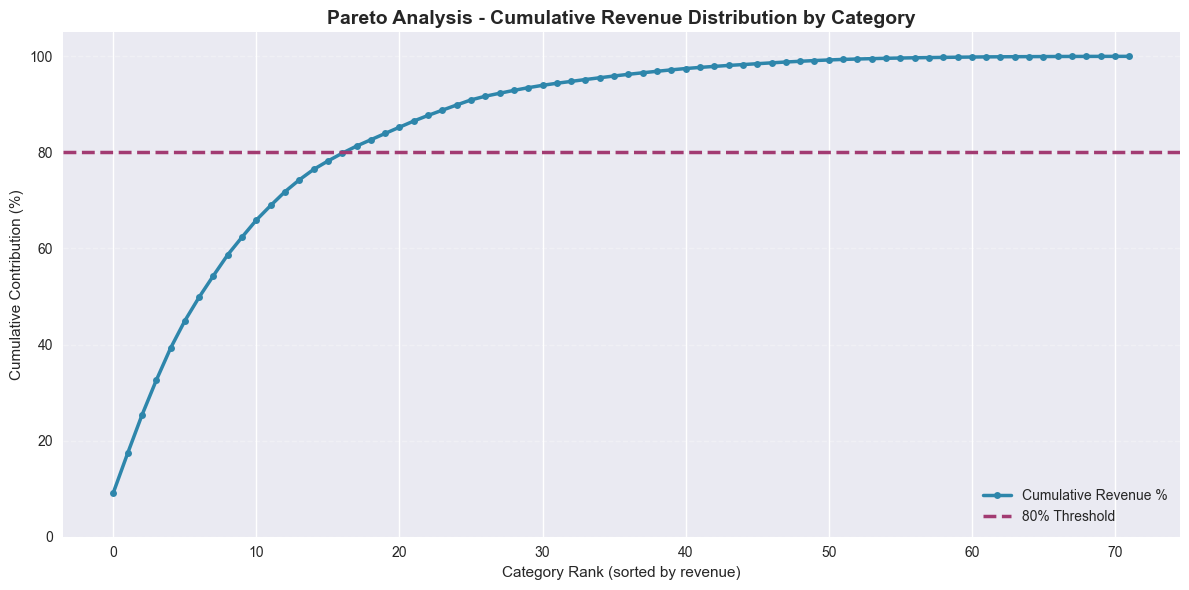

In [25]:
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

# Plot cumulative revenue percentage with markers
plt.plot(category_revenue.index, 
         category_revenue["Cumulative %"],
         marker="o",
         linewidth=2.5,
         color=COLOR_PRIMARY,
         markersize=5,
         label="Cumulative Revenue %")

# Add 80% threshold line
plt.axhline(y=80, color=COLOR_ACCENT, linestyle='--', linewidth=2.5, label="80% Threshold")

# Enhanced styling and annotations
plt.title("Pareto Analysis - Cumulative Revenue Distribution by Category", 
          fontsize=14, fontweight="bold")
plt.xlabel("Category Rank (sorted by revenue)", fontsize=11)
plt.ylabel("Cumulative Contribution (%)", fontsize=11)
plt.grid(axis="y", alpha=0.3, linestyle="--")
plt.legend(fontsize=10, loc="lower right")
plt.ylim(0, 105)

plt.tight_layout()
plt.show()

#### Pareto Insight (80/20 Rule)

The revenue distribution shows strong concentration. Only 17 product categories generate 80% of total revenue, while the remaining categories contribute marginally.

This indicates that strategic focus on top-performing categories could significantly improve overall revenue performance.

Low-performing categories may require optimization, bundling, repositioning, or discontinuation analysis.

## 8. Customer Behavior Overview

#### 8.1 Customer-Level Aggregation

In [26]:
customer_summary = (
    df.groupby("customer_unique_id")
      .agg(
          total_orders=("order_id", "nunique"),
          total_revenue=("revenue", "sum")
      )
      .reset_index()
)

customer_summary.head()

,customer_unique_id,total_orders,total_revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19
2,0000f46a3911fa3c0805444483337064,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,1,196.89


#### 8.2 Repeat vs One-Time Customers

In [27]:
# Identify repeat customers
customer_summary["customer_type"] = customer_summary["total_orders"].apply(
    lambda x: "Repeat" if x > 1 else "One-Time"
)

customer_summary["customer_type"].value_counts()

customer_type
One-Time    90557
Repeat       2801
Name: count, dtype: int64

#### 8.3 Revenue by Customer Type

In [28]:
revenue_by_type = (
    customer_summary.groupby("customer_type")["total_revenue"]
        .sum()
        .reset_index()
)

revenue_by_type

,customer_type,total_revenue
0,One-Time,14555586.29
1,Repeat,864187.46


#### 8.4 Visualization

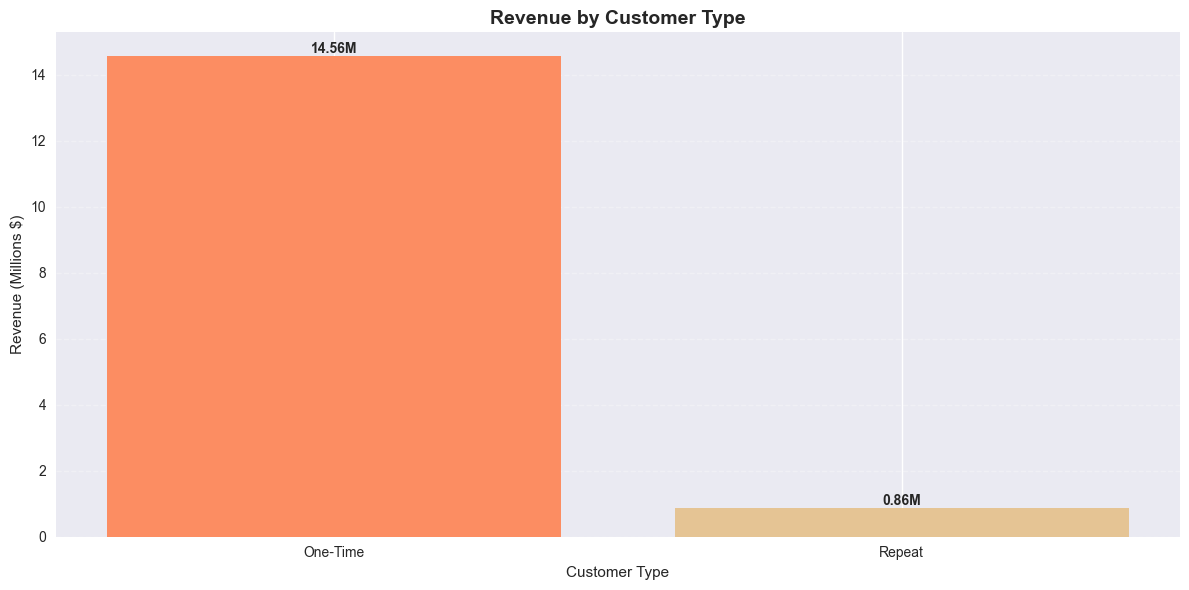

In [29]:
import numpy as np
COLOR_PALETTE = plt.cm.Set2(np.linspace(0.2, 0.8, len(revenue_by_type)))

plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

bars = plt.bar(
    revenue_by_type["customer_type"],
    revenue_by_type["total_revenue"] / 1_000_000,
    color=COLOR_PALETTE
)

plt.title("Revenue by Customer Type", fontsize=14, fontweight="bold")
plt.ylabel("Revenue (Millions $)", fontsize=11)
plt.xlabel("Customer Type", fontsize=11)

plt.grid(axis="y", alpha=0.3, linestyle="--")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f}M',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

#### 8.5 Average Revenue per Customer

In [30]:
customer_summary["avg_order_value"] = (
    customer_summary["total_revenue"] /
    customer_summary["total_orders"]
)

customer_summary.describe()

,total_orders,total_revenue,avg_order_value
count,93358.000000,93358.000000,93358.000000
mean,1.033420,165.168210,160.287465
std,0.209097,226.292101,219.554565
min,1.000000,9.590000,9.590000
25%,1.000000,63.010000,62.330000
50%,1.000000,107.780000,105.630000
75%,1.000000,182.510000,176.590000
max,15.000000,13664.080000,13664.080000


#### Customer Behavior Insight

A significant portion of revenue is driven by repeat customers.
Although one-time customers represent a large share of total customers,
repeat buyers contribute disproportionately to overall revenue.

This highlights the importance of customer retention strategies.

#### 8.6 Repeat Rate Calculation

Total Customers: 93,358
Repeat Customers: 2,801
Repeat Rate: 3.00%


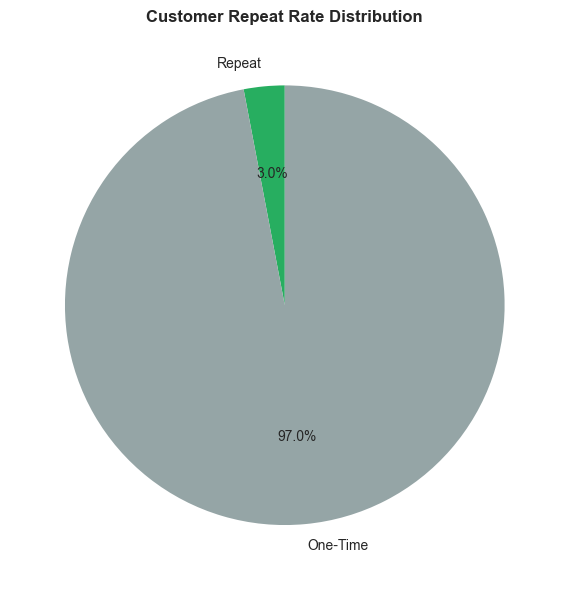

In [31]:
# Total customers
total_customers = customer_summary.shape[0]

# Repeat customers
repeat_customers = customer_summary[
    customer_summary["customer_type"] == "Repeat"
].shape[0]

# Repeat rate
repeat_rate = (repeat_customers / total_customers) * 100

print(f"Total Customers: {total_customers:,}")
print(f"Repeat Customers: {repeat_customers:,}")
print(f"Repeat Rate: {repeat_rate:.2f}%")

plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

labels = ["Repeat", "One-Time"]
sizes = [
    repeat_rate,
    100 - repeat_rate
]

colors = ["#27ae60", "#95a5a6"]

plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)

plt.title("Customer Repeat Rate Distribution", fontweight="bold")
plt.tight_layout()
plt.show()

#### 8.7 Calculate AOV by Customer Type

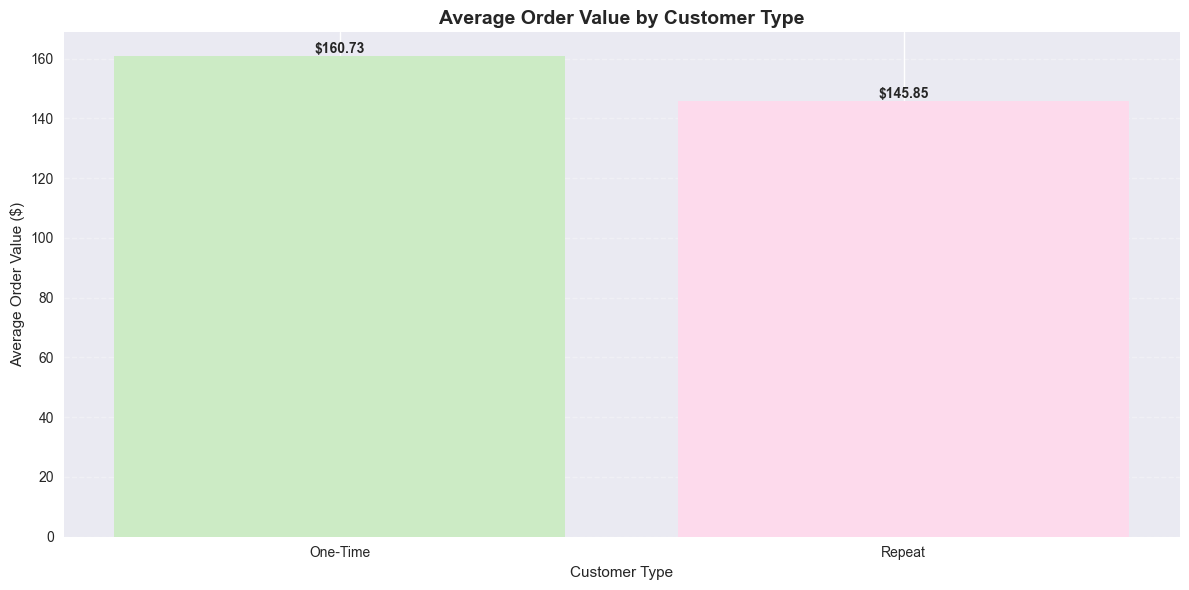

In [32]:
# Average revenue per customer type
aov_by_type = (
    customer_summary.groupby("customer_type")["avg_order_value"]
        .mean()
        .reset_index()
)
aov_by_type

# Color palette
import numpy as np
COLOR_PALETTE = plt.cm.Pastel1(np.linspace(0.3, 0.8, len(aov_by_type)))

plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

bars = plt.bar(
    aov_by_type["customer_type"],
    aov_by_type["avg_order_value"],
    color=COLOR_PALETTE
)

plt.title("Average Order Value by Customer Type", fontsize=14, fontweight="bold")
plt.ylabel("Average Order Value ($)", fontsize=11)
plt.xlabel("Customer Type", fontsize=11)

plt.grid(axis="y", alpha=0.3, linestyle="--")

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'${height:.2f}',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

## 9. Executive Business Summary

#### Revenue Overview
- Total Revenue: ~$15.4M
- Total Delivered Orders: 96,478
- Average Order Value (AOV): ~$159.8

Revenue shows strong growth from 2017 into early 2018, indicating successful acquisition and market expansion.

---

#### Category Performance
- Top 10 categories contribute a significant portion of total revenue.
- Health & Beauty, Watches & Gifts, and Bed & Bath dominate revenue share.
- 17 categories generate 80% of total revenue (Pareto principle observed).

This indicates a concentrated revenue structure, where a limited number of categories drive business performance.

---

#### Customer Behavior Insights
- Total Customers: 93,358
- Repeat Customers: 2,801
- Repeat Rate: ~3%

Customer retention is very low.

---

#### Customer Value Analysis
- One-Time Customer AOV: ~$160.7
- Repeat Customer AOV: ~$145.8

Repeat customers spend less on average compared to first-time buyers.

This suggests:
- Repeat purchasing exists but does not yet represent high-value loyalty.
- Retention strategies may not be optimized.
- Opportunity to increase customer lifetime value (LTV).

---

#### Strategic Recommendations

1. Improve retention strategy (email campaigns, loyalty programs).
2. Target high-performing categories with upsell and cross-sell.
3. Develop CRM-based segmentation for repeat conversion.
4. Analyze churn patterns to understand why customers do not return.

---

#### Final Conclusion

The platform demonstrates strong acquisition and revenue growth,
but long-term sustainability requires improved customer retention and value optimization.

Focus should shift from pure growth to sustainable customer lifetime value expansion.